In [3]:
#Fill these file paths with the locations on your machine. 
PATH_TO_CODE = 'C:/Users/blake/OneDrive/Desktop/Computer Vision/Project/pastis-benchmark/code' # path to the code folder of the repo
PATH_TO_PASTIS = 'D:/PASTIS'


import sys
sys.path.append(PATH_TO_CODE)


import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib

cm = matplotlib.colormaps.get_cmap('tab20')
def_colors = cm.colors
cus_colors = ['k'] + [def_colors[i] for i in range(1,20)]+['w']
cmap = ListedColormap(colors = cus_colors, name='agri',N=21)

def get_rgb(x, batch_index=0, t_show=1):
    """Utility function to get a displayable rgb image 
    from a Sentinel-2 time series.
    """
    im = x['S2'][batch_index, t_show, [2,1,0]].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

def get_radar(x, batch_index=0, t_show=6, orbit='D'):
    """Utility function to get a displayable image 
    from a Sentinel-1 time series.
    """
    im = x['S1{}'.format(orbit)][batch_index, t_show].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

# PASTIS 

In [4]:
from dataloader import PASTIS_Dataset
from collate import pad_collate

dt = PASTIS_Dataset(PATH_TO_PASTIS, norm=True, target='semantic')
# If you only need to evaluate semantic segmentation use target='semantic'

dl = torch.utils.data.DataLoader(dt, batch_size=5, collate_fn=pad_collate, shuffle=True)

Reading patch metadata . . .
Done.
Dataset ready.


In [5]:
# Loading a batch from the dataloader
(x, dates), y = dl.__iter__().__next__()

# x is a dictionary thay contains the Sentinel-2 time series
# in the 'S2' key, shape: B x T x C x H x W
print(x.keys())
print(x['S2'].shape)
# dates contains the observation dates of each image, shape: B x T
print(dates['S2'].shape)
# y is the target label, shape: B x H x W
print(y.shape)


dict_keys(['S2'])
torch.Size([5, 61, 10, 128, 128])
torch.Size([5, 61])
torch.Size([5, 128, 128])


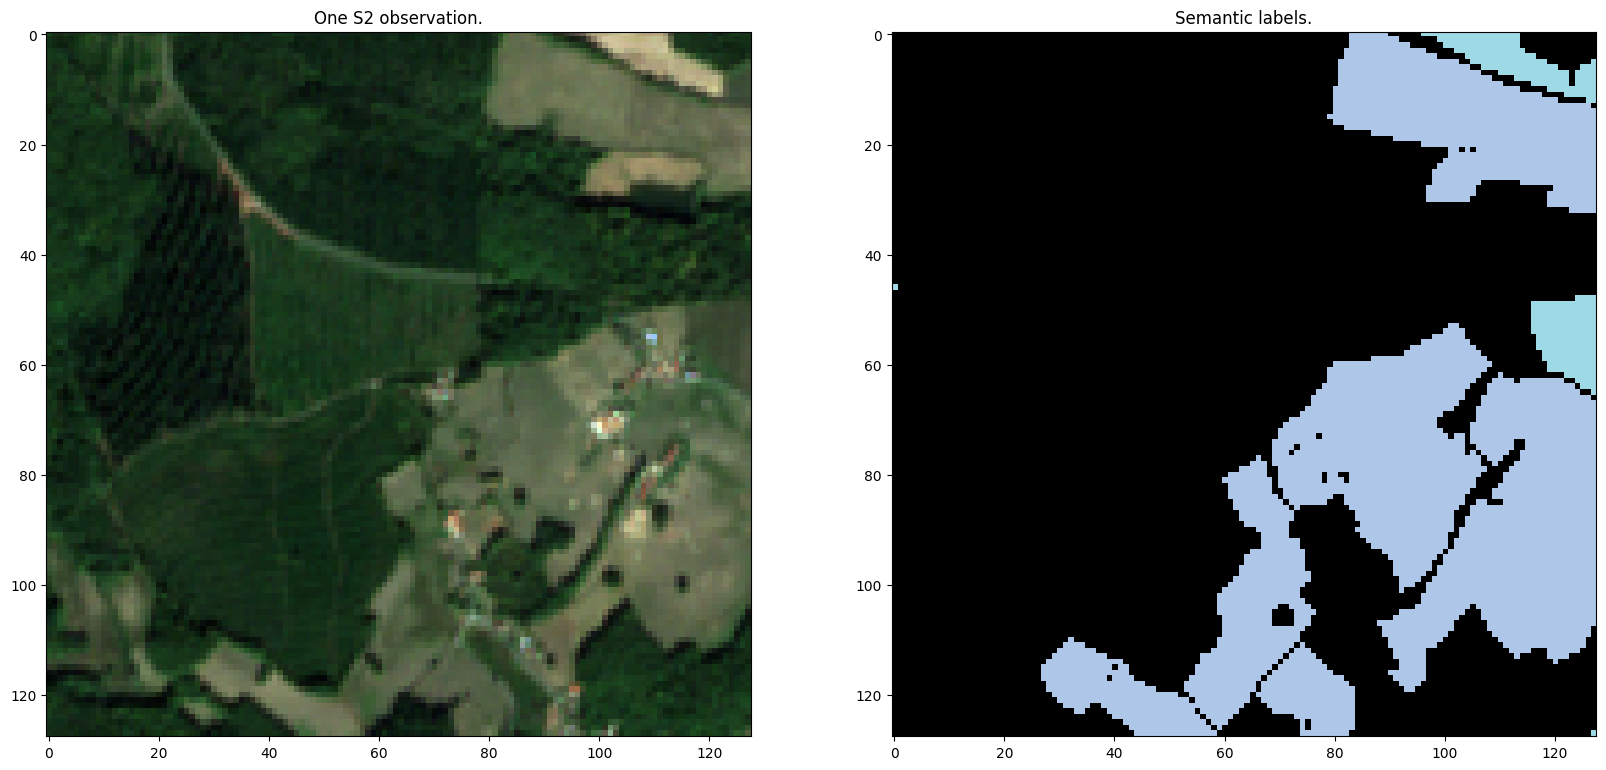

In [6]:
bid = 1 # Which element of the batch to plot

fix, axes = plt.subplots(1,2, figsize=(20,20))

axes[0].imshow(get_rgb(x, batch_index=bid))
# axes[1].imshow(target_heatmap[bid].squeeze())
# axes[2].imshow(instance_ids[bid].squeeze(), cmap='prism', alpha=.6)
axes[1].imshow(y[bid].squeeze(), cmap=cmap, vmin=0, vmax=20)
# print (pixel_semantic_annotation[bid].squeeze().shape)

axes[0].set_title('One S2 observation.')
# axes[1].set_title('Centerness Ground Truth.')
# axes[2].set_title('Instance masks.')
axes[1].set_title('Semantic labels.')

plt.show()

(3, 9994240)
(3, 16384)
Accuracy:  0.261749267578125
F1:  0.35365541910825005
Recall:  0.261749267578125
Precision:  0.7247299775502396


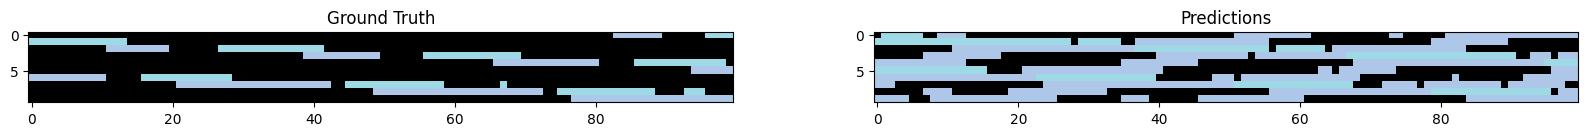

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# Flatten the time series
x_flat = x['S2'].view(x['S2'].shape[0], -1, x['S2'].shape[-2], x['S2'].shape[-1])
x_flat = x_flat.permute(0,2,3,1).view(x_flat.shape[0], -1, x_flat.shape[1])

# Flatten the labels
y_flat = y.view(y.shape[0], -1)

# Split the data
x_train, x_test, y_train, y_test = train_test_split(x_flat.numpy(), y_flat.numpy(), test_size=0.33, random_state=42)

# Initialize and train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)

x_train = x_train.reshape(x_train.shape[0], -1)
print(x_train.shape)
print(y_train.shape)
rf.fit(x_train, y_train)

# Predict
x_test = x_test.reshape(x_test.shape[0], -1)
y_pred = rf.predict(x_test)

# Evaluate
y_test = y_test.flatten()
y_pred = y_pred.flatten()

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)

print('Accuracy: ', accuracy)
print('F1: ', f1)
print('Recall: ', recall)
print('Precision: ', precision)

# Plot the first 1000 pixels of the test set
fig, axes = plt.subplots(1,2, figsize=(20,20))

axes[0].imshow(y_test[:1000].reshape(10,100), cmap=cmap, vmin=0, vmax=20)

axes[1].imshow(y_pred[:1000].reshape(10,100), cmap=cmap, vmin=0, vmax=20)

axes[0].set_title('Ground Truth')

axes[1].set_title('Predictions')

plt.show()